### Usando SqueezeNet en HyperFace

Seeing that Hyperface with VGG16 as main model is so big, we decide to try to train in a 'smaller' architecture (SqueezeNet https://arxiv.org/abs/1602.07360v3).

Reducing the size of AlexNet:
- SVD: 5x compression, 56% top-1 accuracy
- Pruning: 9x compression, 57.2% top-1 accuracy
- Deep Compression: 35x compression, ~57% top-1 accuracy
- SqueezeNet: 50x compression, ~57% top-1 accuracy

In [25]:
from keras import backend as K
from keras.models import Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, Dropout, GlobalAveragePooling2D, merge
from keras.layers.merge import concatenate
from keras.regularizers import l2
from keras import applications
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.optimizers import Adam, RMSprop
import keras.backend as kb
import keras.losses as losses
import tensorflow as tf
import os
import time
import numpy as np
import h5py
import squeeze
import hf

#### 1. Replicando la arquitectura del modelo

- La red ya tiene pesos entrenados.
- Obviamos la capa de clasificación de Squeeze.
- ¿Cómo hacer fine-tuning?

<!-- <img src="squeezenet-architecture.png"/> -->

In [3]:
model = squeeze.SqueezeNet()
model = Model(inputs=model.input, outputs=model.get_layer('drop9').output)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

**Principales diferencias con el paper original**
- Se usa una profundidad de 128 en vez de 256, por lo que la Combinación es de 384 en vez de 768
- Para las "hypercaracterísticas" se usan las capas que más se asemejan a las del paper original:
    - Para 1er grupo se usa "pool3" 27x27x128 a diferencia de 27x27x96
    - Para 2do grupo se usa "pool5" 13x13x256 a diferencia de 13x13x384
    - Para 3er grupo se usa "drop9" 13x13x512 a diferencia de 6x6x256
- Para la Reducción se usa 6x6x96 en vez de 6x6x192 (al parecer hay un error en el paper)

<img src="HyperFace-architecture.small.png"/>

In [21]:
#
# Hypercaracterísticas
#

# 1er grupo de hypercaracterísticas: "conv1a" - se asume usar kernel y strides adecuados
conv1a_input = model.get_layer('pool3').output
conv1a = Convolution2D(128, (4,4), strides=(4,4), activation='relu', padding='valid', name='conv1a')(conv1a_input)
print("hypercaracterísticas #1 - in:", conv1a_input.shape, 'out:', conv1a.shape)

# 2do grupo de hypercaracterísticas: "conv3a"
conv3a_input = model.get_layer('pool5').output
conv3a = Convolution2D(128, (2,2), strides=(2,2), activation='relu', padding='valid', name='conv3a')(conv3a_input)
print("hypercaracterísticas #2 - in:", conv3a_input.shape, 'out:', conv3a.shape)

# 3er grupo de hypercaracterísticas: "conv5a"
conv5a_input = model.get_layer('drop9').output
conv5a = Convolution2D(128, (2,2), strides=(2,2), activation='relu', padding='valid', name='conv5a')(conv5a_input)
print("hypercaracterísticas #3 - in:", conv5a_input.shape, 'out:', conv5a.shape)

# Combinación: 6x6x384
concat = concatenate([conv1a, conv3a, conv5a], axis=-1, name='concat')
print("combinación:", concat.shape)

# Reducción de dimensión: 6x6x96
conv_all = Convolution2D(96, (1, 1), strides=(1,1), activation='relu', padding='valid', name='conv_all')(concat)
print("reducción:", conv_all.shape)

# completamente conectadas
fc_full = Flatten(input_shape=conv_all.shape, name='fc_full')(conv_all)
# print(fc_full.shape)

#
# Cabezas de clasificación
#

# rostro/no rostro
fc_detecton = Dense(256, name='fc_detecton', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
face_nonface = Dense(2, name='face_nonface', activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_detecton)
print("rostro/no rostro - in:", fc_detecton.shape, "out:", face_nonface.shape)

# puntos característicos
fc_landmarks = Dense(256, name='fc_landmarks', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
landmarks = Dense(42, name='landmarks', activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_landmarks)
print("puntos característicos - in:", fc_landmarks.shape, "out:", landmarks.shape)

# visibilidad
fc_visibility = Dense(256, name='fc_visibility', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
visibility = Dense(21, name='visibility', activation='sigmoid', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_visibility)
print("visibilidad - in:", fc_visibility.shape, "out:", visibility.shape)

# pose
fc_pose = Dense(256, name='fc_pose', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
roll_pitch_yaw = Dense(3, name='roll_pitch_yaw', activation='linear', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_pose)
print("pose - in:", fc_pose.shape, "out:", roll_pitch_yaw.shape)

# género
fc_gender = Dense(256, name='fc_gender', activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_full)
male_female = Dense(2, name='male_female', activation='softmax', kernel_initializer='he_normal', kernel_regularizer=l2(0.00))(fc_gender)
print("género - in:", fc_gender.shape, "out:", male_female.shape)

hypercaracterísticas #1 - in: (?, 27, 27, 128) out: (?, 6, 6, 128)
hypercaracterísticas #2 - in: (?, 13, 13, 256) out: (?, 6, 6, 128)
hypercaracterísticas #3 - in: (?, 13, 13, 512) out: (?, 6, 6, 128)
combinación: (?, 6, 6, 384)
reducción: (?, 6, 6, 96)
rostro/no rostro - in: (?, 256) out: (?, 2)
puntos característicos - in: (?, 256) out: (?, 42)
visibilidad - in: (?, 256) out: (?, 21)
pose - in: (?, 256) out: (?, 3)
género - in: (?, 256) out: (?, 2)


In [22]:
hyperface = Model(inputs=model.input, outputs=[face_nonface, landmarks, visibility, roll_pitch_yaw, male_female])
hyperface.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 227, 227, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 113, 113, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
relu_conv1 (Activation)          (None, 113, 113, 64)  0           conv1[0][0]                      
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 56, 56, 64)    0           relu_conv1[0][0]                 
___________________________________________________________________________________________

#### 2. Definiendo las funciones de pérdida y el algoritmo de aprendizaje
- Algunas versiones de Keras verifican que _y_ predecido y _y_ real tengan las mismas dimensiones, en Hyperface el cálculo de error de los landmarks toma en cuenta la visibilidad.
- Se ignora la visibilidad en el cálculo de la pérdida para los landmarks

In [24]:
def custom_loss_visibility(y_true, y_pred):
    # en paper: loss = 1/N * sum((vpredi-vi)^2)
    # para entrenar:
    return (1/21) * kb.sum(kb.square(y_pred-y_true), axis=-1)
    # para debug:
    # return (1/21) * np.sum((y_pred-y_true)**2, axis=-1)

def custom_loss_pose(y_true, y_pred):
    # en paper: loss = 1/3 * sum((ppredi-pi)^2)
    # para entrenamiento:
    return (1/3) * kb.sum(kb.square(y_pred-y_true), axis=-1)
    # para debug:
    # return (1/3) * np.sum((y_pred-y_true)**2, axis=-1)

def custom_loss_landmarks(coord_true, coord_pred):    
    # en paper: loss = 1/(2N) * Sum(vi*((xpredi-ai)^2 + (ypredi-bi)^2))
    x_true_coord = coord_true[:,0:21]
    y_true_coord = coord_true[:,21:42]
    # viz_true = coord_true[:,42:63]  # produce errores en otros entornos (versión de keras?)
    x_pred_coord = coord_pred[:,0:21]
    y_pred_coord = coord_pred[:,21:42]
    # para entrenamiento:
    # return (1/(2*21)) * kb.sum(viz_true * (kb.square(x_pred_coord-x_true_coord) + K.square(y_pred_coord - y_true_coord)), axis=-1)
    return (1/(2*21)) * kb.sum((kb.square(x_pred_coord-x_true_coord) + K.square(y_pred_coord - y_true_coord)), axis=-1)
    # para debug:
    # return (1/(2*21)) * np.sum(viz_true * ((x_pred_coord-x_true_coord)**2 + (y_pred_coord - y_true_coord)**2), axis=-1)

def custom_mse_lm(y_true,y_pred):
    return kb.sign(kb.sum(kb.abs(y_true),axis=-1))*kb.sum(kb.square(tf.multiply((kb.sign(y_true)+1)*0.5, y_true-y_pred)),axis=-1)/kb.sum((kb.sign(y_true)+1)*0.5,axis=-1)

optimizer = Adam(lr=0.0001)

hyperface.compile(optimizer=optimizer,
                  loss={
                      'face_nonface': 'categorical_crossentropy',
                      'landmarks': custom_loss_landmarks,
                      'visibility': custom_loss_visibility,
                      'roll_pitch_yaw': custom_loss_pose,
                      'male_female': 'categorical_crossentropy'},
                  loss_weights={
                      'face_nonface': 1,
                      'landmarks': 1,
                      'visibility': 1,
                      'roll_pitch_yaw': 1,
                      'male_female': 1})

print("Modelo compilado")

Modelo compilado


#### 3. Preparando conjunto de datos de entrenamiento y de validación
Corregir imágenes JPGs no válidas usando ImageMagick:
- `convert -resize 50% /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg`
- `convert -resize 200% /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg /home/lmiguel/Projects/datasets/aflw/aflw/data/flickr/3/image21068.jpg`

In [28]:
print("Iterables para el conjunto de entrenamiento y validación")

json_dir = os.path.dirname(os.path.realpath('__file__'))  # genérico

train_data = hf.ImageDataGeneratorV2(samplewise_center=True, samplewise_std_normalization=True)
train_data_flow = train_data.flow_from_directory(json_dir,
                                                 # 'negatives5k-train.json', 'positives5k-train.json', 
                                                 # pos_max_load_labels=12116, neg_max_load_labels=12116*3,
                                                 'positives.json', 'negatives.json', 
                                                 pos_max_load_labels=2, neg_max_load_labels=2,
                                                 output_type='hyperface', target_size=(227, 227),
                                                 pos_batch_size=64, neg_batch_size=64)

val_data = hf.ImageDataGeneratorV2(samplewise_center=True,            
                                    samplewise_std_normalization=True)
val_data_flow = val_data.flow_from_directory(json_dir, 
                                             # 'negatives5k-test.json', 'positives5k-test.json', 
                                             # pos_max_load_labels=505, neg_max_load_labels=505*3, #Número de negativos 18938
                                             'positives.json', 'negatives.json', 
                                             pos_max_load_labels=2, neg_max_load_labels=2,
                                             output_type='hyperface', target_size=(227, 227),
                                             pos_batch_size=64, neg_batch_size=64)


Iterables para el conjunto de entrenamiento y validación
Found 2 positive samples and 2 negative samples.
Found 2 positive samples and 2 negative samples.
Start training...
Epoch 1/5
100/100 [==============================] - 6s - loss: 0.0130 - face_nonface_loss: 1.1645e-04 - landmarks_loss: 0.0122 - visibility_loss: 3.1778e-04 - roll_pitch_yaw_loss: 3.0511e-04 - male_female_loss: 1.8244e-06 - val_loss: 0.0086 - val_face_nonface_loss: 4.9712e-05 - val_landmarks_loss: 0.0083 - val_visibility_loss: 1.2026e-04 - val_roll_pitch_yaw_loss: 6.7823e-05 - val_male_female_loss: 7.7486e-07
Epoch 2/5
100/100 [==============================] - 6s - loss: 0.0060 - face_nonface_loss: 3.4055e-05 - landmarks_loss: 0.0057 - visibility_loss: 8.0993e-05 - roll_pitch_yaw_loss: 9.1921e-05 - male_female_loss: 5.5730e-07 - val_loss: 0.0037 - val_face_nonface_loss: 2.3470e-05 - val_landmarks_loss: 0.0035 - val_visibility_loss: 5.4496e-05 - val_roll_pitch_yaw_loss: 1.1052e-04 - val_male_female_loss: 3.7253e-07

#### 4. Ejecutando entrenamiento

In [ ]:
# # checkpoint
# filepath="weights-{epoch:02d}-{loss:.2f}.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='train_loss', verbose=1, save_best_only=False, mode='min', period=30)
# callbacks_list = [checkpoint]

print("Start training...")
# history = hyperface.fit_generator(train_data_flow, steps_per_epoch=100, epochs=300, callbacks=callbacks_list)
history = hyperface.fit_generator(generator=train_data_flow, 
                                  validation_data=val_data_flow,
                                  validation_steps=100,
                                  steps_per_epoch=100, epochs=5) 
#                                   steps_per_epoch=100, epochs=30)

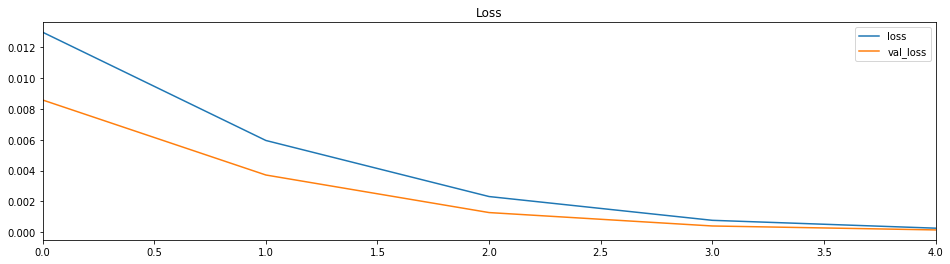

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(history.history)
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
# df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy')
# df.plot(y=['loss'], figsize=(12,4), title='Loss')
# df

#### 5. Guardando modelo

In [32]:
import h5py

model_weights_file = 'hyperface.weights.h5'
model_yaml_file = 'hyperface.model.yaml'

hyperface.save_weights(model_weights_file)
model_yaml = hyperface.to_yaml()
with open(model_yaml_file, 'w') as yaml_file:
    yaml_file.write(model_yaml)

print('Modelo escrito')

Modelo escrito


#### 6. Cargar modelo y realizar predicciones 
https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [35]:
from keras.models import model_from_yaml

model_weights_file = 'hyperface.weights.h5'
model_yaml_file = 'hyperface.model.yaml'

yaml_file = open(model_yaml_file, 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()

loaded_model = model_from_yaml(loaded_model_yaml)
loaded_model.load_weights(model_weights_file)
print("Modelo cargado")

# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

data_flow = train_data.flow_from_directory(json_dir,
                                           # 'negatives5k-train.json', 'positives5k-train.json', 
                                           # pos_max_load_labels=12116, neg_max_load_labels=12116*3, #Número de negativos 454512
                                           'positives.json', 'negatives.json', 
                                           pos_max_load_labels=2, neg_max_load_labels=2,
                                           output_type='predict', target_size=(227, 227),
                                           pos_batch_size=64, neg_batch_size=64)
batch_x, batch_image, batch_bbox, batch_y_fnf, batch_y_landmarks, batch_y_visfac, batch_y_pose, batch_y_gender = data_flow.next()

# DO NOT LOAD LIKE THIS, USE A REGION FIRST!
# path = batch_image[0]
# print("loading", path)
# img = image.load_img(path, target_size=(227, 227))
# x = image.img_to_array(img)
# x = train_data.standardize(x)
# x = np.expand_dims(x, axis=0)

subject = 0
x = batch_x[subject]
x = np.expand_dims(x, axis=0)

preds = loaded_model.predict(x)

print('Predicciones: (face_nonface, landmarks, visibility, roll_pitch_yaw, male_female)')

print('face_nonface ground truth:')
print(batch_y_fnf[subject])
print('face_nonface predicted:')
print(preds[0])
print()

print('landmarks ground truth:')
print(batch_y_landmarks[subject])
print('landmarks predicted:')
print(preds[1])
print()

print('visibility ground truth:')
print(batch_y_visfac[subject])
print('visibility predicted:')
print(preds[2])
print()

print('pose ground truth:')
print(batch_y_pose[subject])
print('pose predicted:')
print(preds[3])
print()

print('gender ground truth:')
print(batch_y_gender[subject])
print('gender predicted:')
print(preds[4])
print()

Modelo cargado
Found 2 positive samples and 2 negative samples.
Predicciones: (face_nonface, landmarks, visibility, roll_pitch_yaw, male_female)
face_nonface ground truth:
[1 0]
face_nonface predicted:
[[  9.99984622e-01   1.54308236e-05]]

landmarks ground truth:
[-0.02621928  0.09466667  0.188       0.34266667  0.41733333 -0.5
  0.00933333  0.05733333  0.132      -0.5         0.30533333  0.364
 -0.32133333  0.10533333  0.23866667 -0.5        -0.5        -0.01741842
  0.11866667  0.16740007 -0.00666667 -0.25212114 -0.23819742 -0.19957082
 -0.13519313 -0.13519313 -0.5        -0.18454936 -0.17811159 -0.13733906
 -0.5        -0.10085837 -0.08154506 -0.15236052  0.04506438  0.0751073
 -0.5        -0.5         0.1315009   0.16094421  0.17517483  0.29184549]
landmarks predicted:
[[-0.01352352  0.10265375  0.18856715  0.34204283  0.48043934 -0.49332458
   0.00913848  0.0459731   0.13369177 -0.4705711   0.30826566  0.37652618
  -0.2649478   0.10850015  0.23642007 -0.5034166  -0.51587486 -0.01

#### 7. Modelo sin visibilidad y puntos característicos

In [11]:
hyperface_faceposegender = Model(inputs=model.input, outputs=[face_nonface, roll_pitch_yaw, male_female])
optimizer = Adam(lr=0.0001)
hyperface_faceposegender.compile(optimizer=optimizer,
                  loss={
                      'face_nonface': 'categorical_crossentropy',
                      'roll_pitch_yaw': custom_loss_pose,
                      'male_female': 'categorical_crossentropy'},
                  loss_weights={
                      'face_nonface': 1,
                      'roll_pitch_yaw': 1,
                      'male_female': 1})
print("hyperface_faceposegender model compiled")

json_dir = os.path.dirname(os.path.realpath('__file__')) # genérico
train_data = hf.ImageDataGeneratorV2(samplewise_center=True,                                     
                                     samplewise_std_normalization=True)
train_data_flow = train_data.flow_from_directory(json_dir,
                                                 'positives.json3k', 'negatives.json3k', 
                                                 # 'positives.json', 'negatives.json', 
                                                 pos_max_load_labels=2, neg_max_load_labels=2,
                                                 output_type='faceposegender', target_size=(227, 227),
                                                 pos_batch_size=64, neg_batch_size=64)
print("training...")
history = hyperface_faceposegender.fit_generator(generator=train_data_flow, 
                                  steps_per_epoch=100, epochs=5)

hyperface_faceposegender model compiled
Found 2 positive samples and 2 negative samples.
training...
Epoch 1/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1951e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     
Epoch 2/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1921e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     
Epoch 3/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1921e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     
Epoch 4/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1921e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     
Epoch 5/5
100/100 [==============================] - 3s - loss: 0.0188 - face_nonface_loss: 1.1921e-07 - roll_pitch_yaw_loss: 0.0188 - male_female_loss: 2.9802e-08     
